# Ising model on square lattice

We will study the 2D Ising model on a square lattice, 
$$
H=-J\sum_{\langle ij\rangle} \sigma_i \sigma_j -h \sum_i \sigma_i,
$$
where $\langle ij \rangle$ indicates the nearest-neighbor pair. 

This code can be further optimized by rethinking how energy should be calculated more efficiently and use type specialization. 

In [7]:
#using Pkg; Pkg.add("Plots")

using Plots
using Statistics
gr()

Plots.GRBackend()

## Initialize the spin configuration

$s$ array holds the spin configuration

In [8]:
function initialize(L::Int64)
  s=[ Int8(rand(0:1) == 0 ? -1 : 1) for i in 1: L^2]
  return reshape(s, L, L)
end

initialize (generic function with 1 method)

## Metropolis step

Filp the spin at site $(i,j)$, and accept the new configuration with the probability $\min(1,\exp(-\beta\Delta E))$

In [9]:
function update(temp::Float64, s, L::Int64)
  N=L*L
  for step in 1 : N
        i, j = rand(1:L), rand(1:L)
        s′=s[i,j]
        ΔE=2.0*J*s′*(s[(i+L-2)%L+1,j]+s[(i+L)%L+1,j]+s[i,(j+L-2)%L+1]+s[i,(j+L)%L+1])+2.0*h*s′
        if(rand()<exp(-ΔE/temp))
            s[i,j]=-s′
        end
    end
end

update (generic function with 1 method)

## Measurement

Notice that this way of computing the total energy is expensive,  $O(L^2)$. 

In [10]:
function calM(s::Array{Int8})
    return sum(s)
end

function calE(s::Array{Int8}, L)
    E=0.0
    for i in 1:L
        for j in 1:L
            s′= s[i, j]
            E -= J*s′*(s[(i+L-2)%L+1,j]+s[(i+L)%L+1,j]+s[i,(j+L-2)%L+1]+s[i,(j+L)%L+1])
        end
    end
    return E/2.0;
end

calE (generic function with 1 method)

## Main program

In [11]:

L=8::Int64; 
const J=1.0 
const h=0.0
const EQU=40000
const MCS=20000
const nBin=10


N=L*L

M_all=zeros(nBin)
absM_all=zeros(nBin)
M2_all=zeros(nBin)
E_all=zeros(nBin)
E2_all=zeros(nBin)
M4_all=zeros(nBin)
M_T=[]
absM_T=[]
E_T=[]
Cv_T=[]
χ_T=[]
U2_T=[]
temps=range(4, stop=2., length=21)
s=initialize(L)
@show(s)

for temp in temps

    for i in 1:EQU
        update(temp, s, L)
    end
    for bin in 1:nBin
        M_bin=0.0
        absM_bin=0.0
        E_bin=0.0
        E2_bin=0.0
        M2_bin=0.0
        M4_bin=0.0
        for i in 1:MCS
            update(temp, s, L)
            M=calM(s)/N
            M2=M*M
            E=calE(s, L)/N
            E2=E*E
            M4= M^4
            M_bin += M
            absM_bin += abs(M)
            M2_bin += M2
            E_bin += E
            E2_bin += E2
            M4_bin += M4
        end
        M_all[bin]=M_bin/Float64(MCS)
        absM_all[bin]=absM_bin/Float64(MCS)
        M2_all[bin]=M2_bin/Float64(MCS)
        E_all[bin]=E_bin/Float64(MCS)
        E2_all[bin]=E2_bin/Float64(MCS)
        M4_all[bin]=M4_bin/Float64(MCS)
    #print("++++++++++++++ $M4_bin");

    end
    M_ave=mean(M_all)
    absM_ave=mean(absM_all)
    M2_ave=mean(M2_all)
    E_ave=mean(E_all)
    E2_ave=mean(E2_all)
    M4_ave=mean(M4_all)
    R2=M4_ave/(M2_ave^2)
    U2=(3.0/2.0)*(1.0-(1.0/3.0)*R2)
    if(temp<1.0e-14)
        Cv=0.0
        χ=0.0
    else
        Cv=(E2_ave-E_ave*E_ave)/(temp*temp)
        χ=(M2_ave-M_ave*M_ave)/temp
    end
    Cv *= N; χ *= N;
    println("$temp	$M_ave	$E_ave  $Cv  $χ  $U2")
    append!(M_T, M_ave)
    append!(absM_T, absM_ave)
    append!(E_T, E_ave)
    append!(Cv_T, Cv)
    append!(χ_T, χ)
    append!(U2_T, U2)
end






s = Int8[1 -1 1 1 -1 -1 1 1; -1 1 1 1 -1 -1 -1 1; 1 1 1 -1 1 1 -1 1; -1 1 -1 1 1 -1 1 1; 1 1 1 1 -1 1 1 -1; 1 -1 1 -1 1 -1 1 1; -1 1 1 -1 -1 -1 -1 1; 1 1 -1 -1 -1 -1 1 -1]
4.0	-0.0026134375	-0.5581553125000001  0.17470738538710906  1.0622105628609373  0.1410115902075072
3.9	0.0018564062500000002	-0.5759243749999999  0.18579906732248566  1.1554042635572916  0.16203540675050732
3.8	0.0009739062500000003	-0.59503625  0.20119419085180035  1.2652808181377468  0.17238454042424928
3.7	-0.00356453125	-0.6160056249999999  0.21789718611943065  1.3903556448610639  0.19343842553527535
3.6	-0.00017390624999999993	-0.64032625  0.23933443579475278  1.5630514588676219  0.2046217483084769
3.5	0.00023937499999999984	-0.664701875  0.2622398540224491  1.7350096665071426  0.2281047965666086
3.4	0.00038671875	-0.6934431249999999  0.2919655685964535  1.9738224606502757  0.2503551341899829
3.3	0.0029515625	-0.7229218749999999  0.32414472997015686  2.233966651467803  0.2816529898658507
3.2	0.00115328125	-0.757

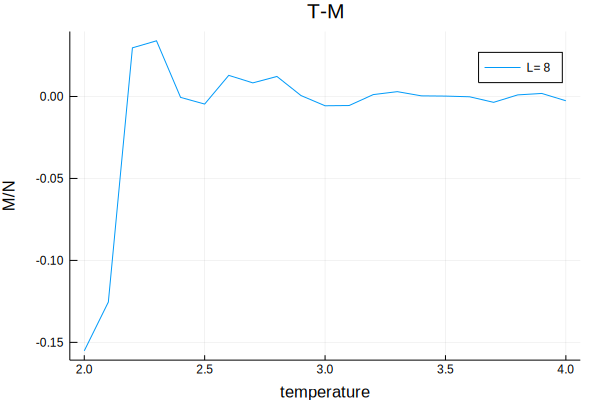

In [15]:

plot(temps, M_T, label="L= $L", legend=:topright)
title!("T-M") 
xlabel!("temperature")
ylabel!("M")




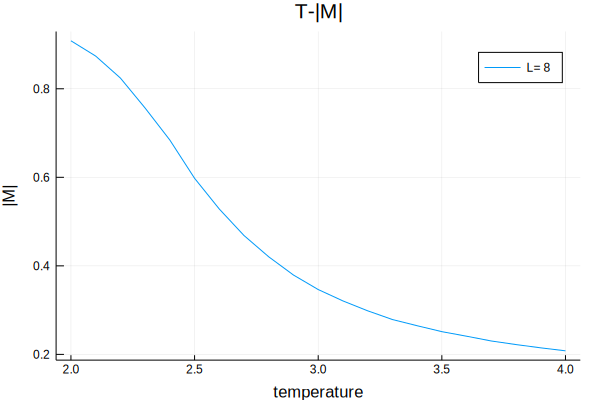

In [18]:

plot(temps, absM_T, label="L= $L")
title!("T-|M|")
xlabel!("temperature")
ylabel!("|M|")


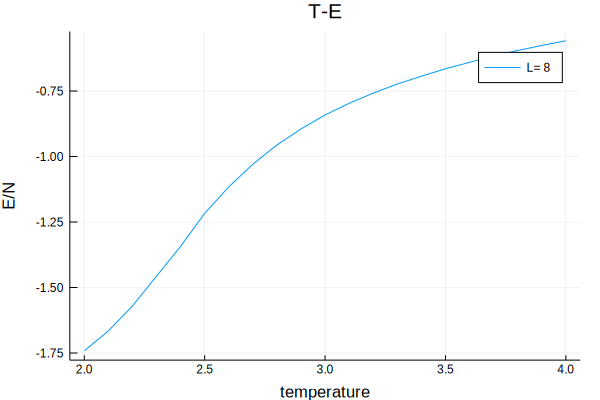

In [19]:

plot(temps, E_T, label="L= $L")
title!("T-E")
xlabel!("temperature")
ylabel!("E/N")



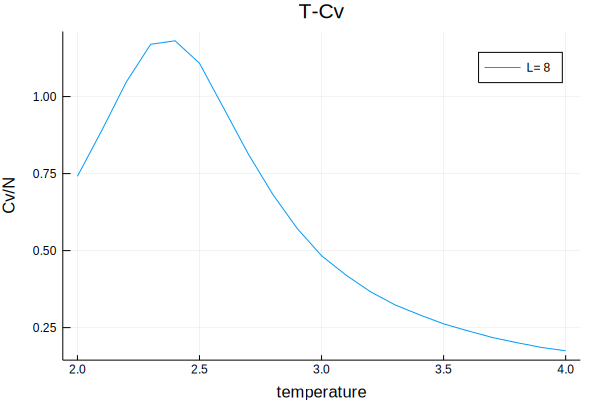

In [20]:

plot(temps, Cv_T, label="L= $L")
title!("T-Cv")
xlabel!("temperature")
ylabel!("Cv/N")


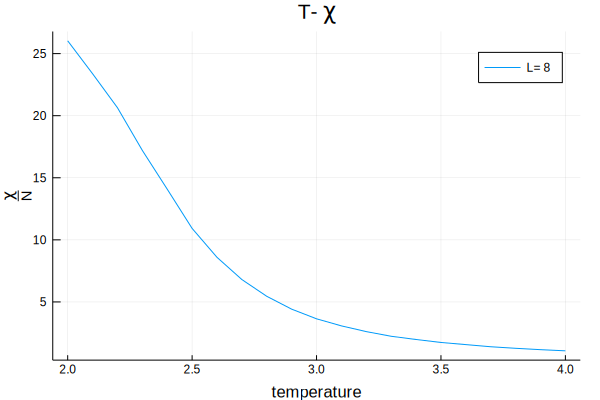

In [26]:

plot(temps, χ_T, label="L= $L")
title!("T-\\chi")
xlabel!("temperature")
ylabel!("\\chi/N")


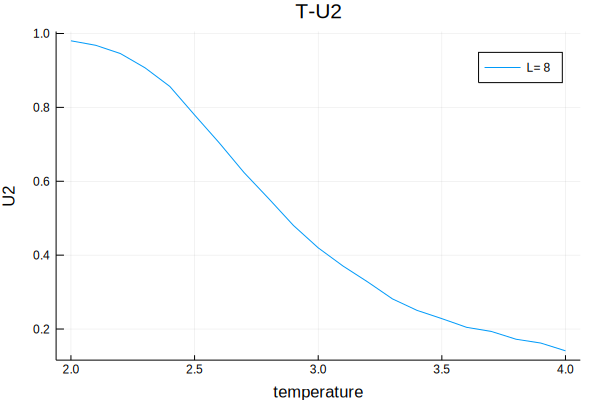

In [21]:

plot(temps, U2_T, label="L= $L")
title!("T-U2")
xlabel!("temperature")
ylabel!("U2")